In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from pathlib import Path

In [9]:
def csv_dirs(data_folder:str)->list:
    dirs = glob.glob(f"{Path(data_folder)/'**'}", recursive=True)
    csv_dirs = []
    for path in dirs:
        if ".csv" in path:
            csv_dirs.append(path)
    return csv_dirs


def plot_dataframe(df: pd.DataFrame, title: str = ""):
    epochs = df["Epoch"]
    acc = df["Accuracy"]
    loss = df["Average_loss"]
    plt.figure(figsize=(20, 20))
    plt.subplot(2, 1, 1)
    plt.title(title)
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(epochs, acc)
    plt.subplot(2, 1, 2)
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Average_loss")
    plt.plot(epochs, loss, color="r", ls="--")
    plt.tight_layout()
    plt.show()


def per_class_acc_hist():
    pass


def confusion_matrix():

    pass



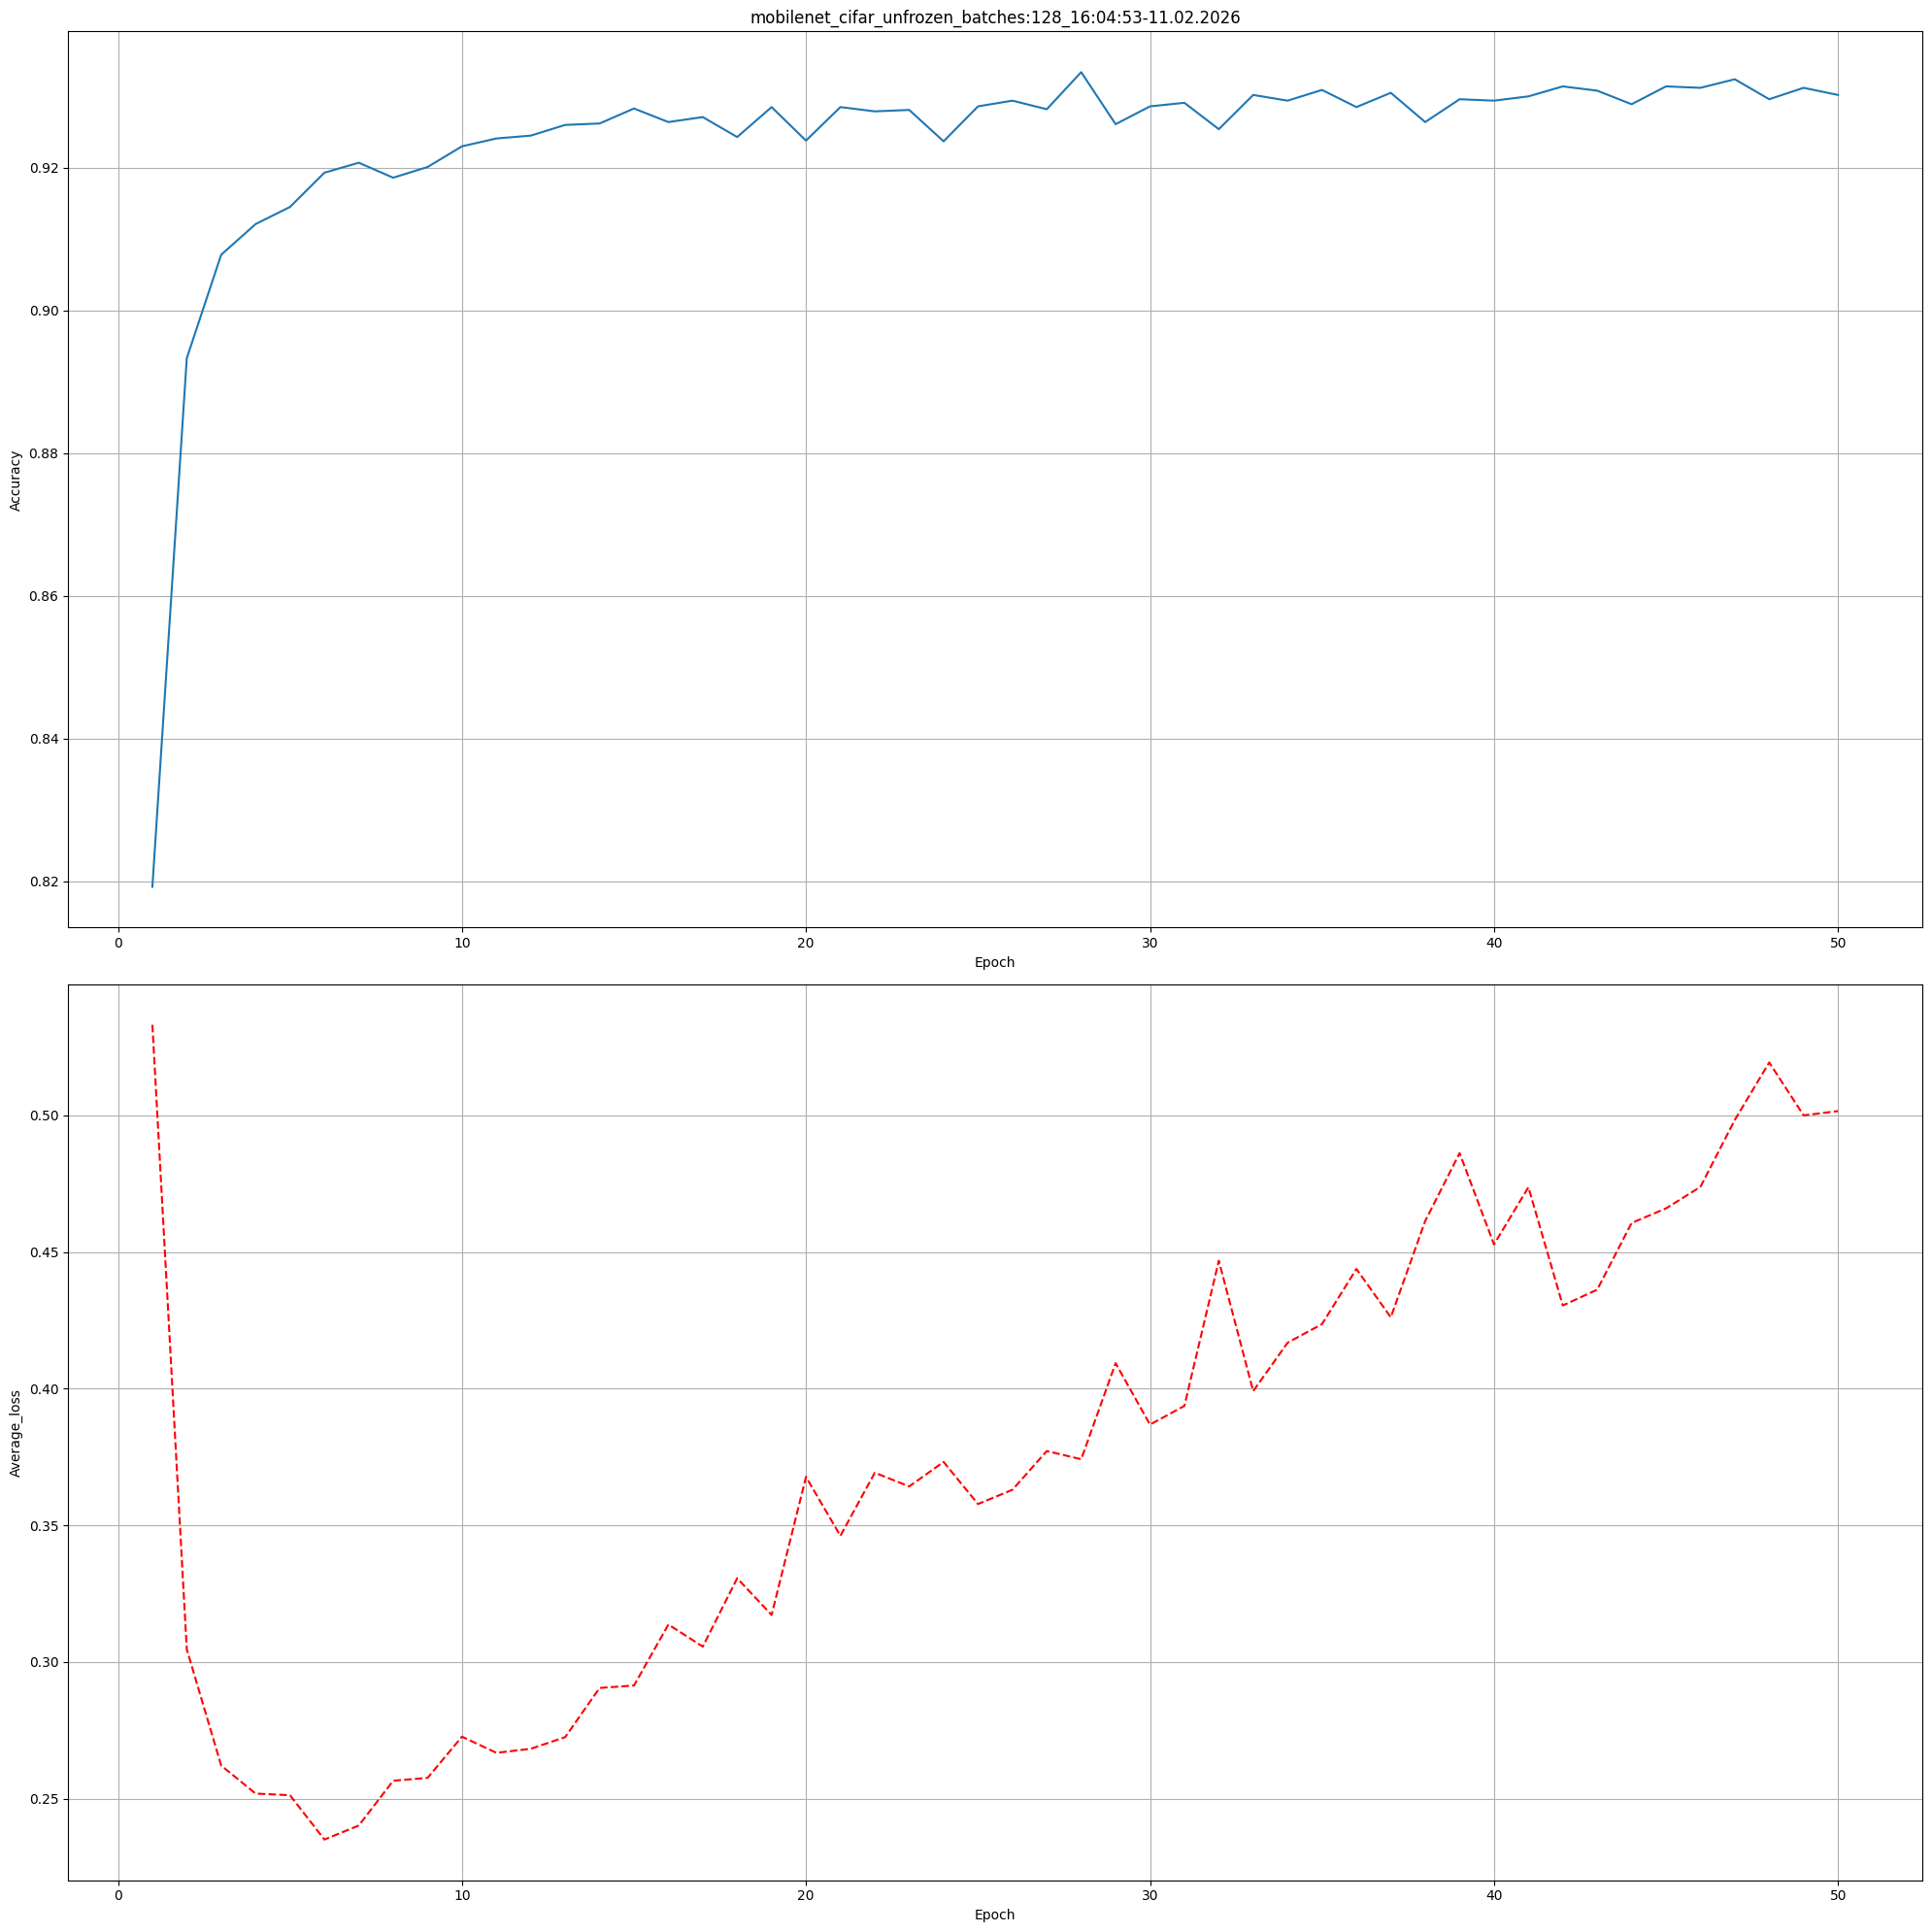

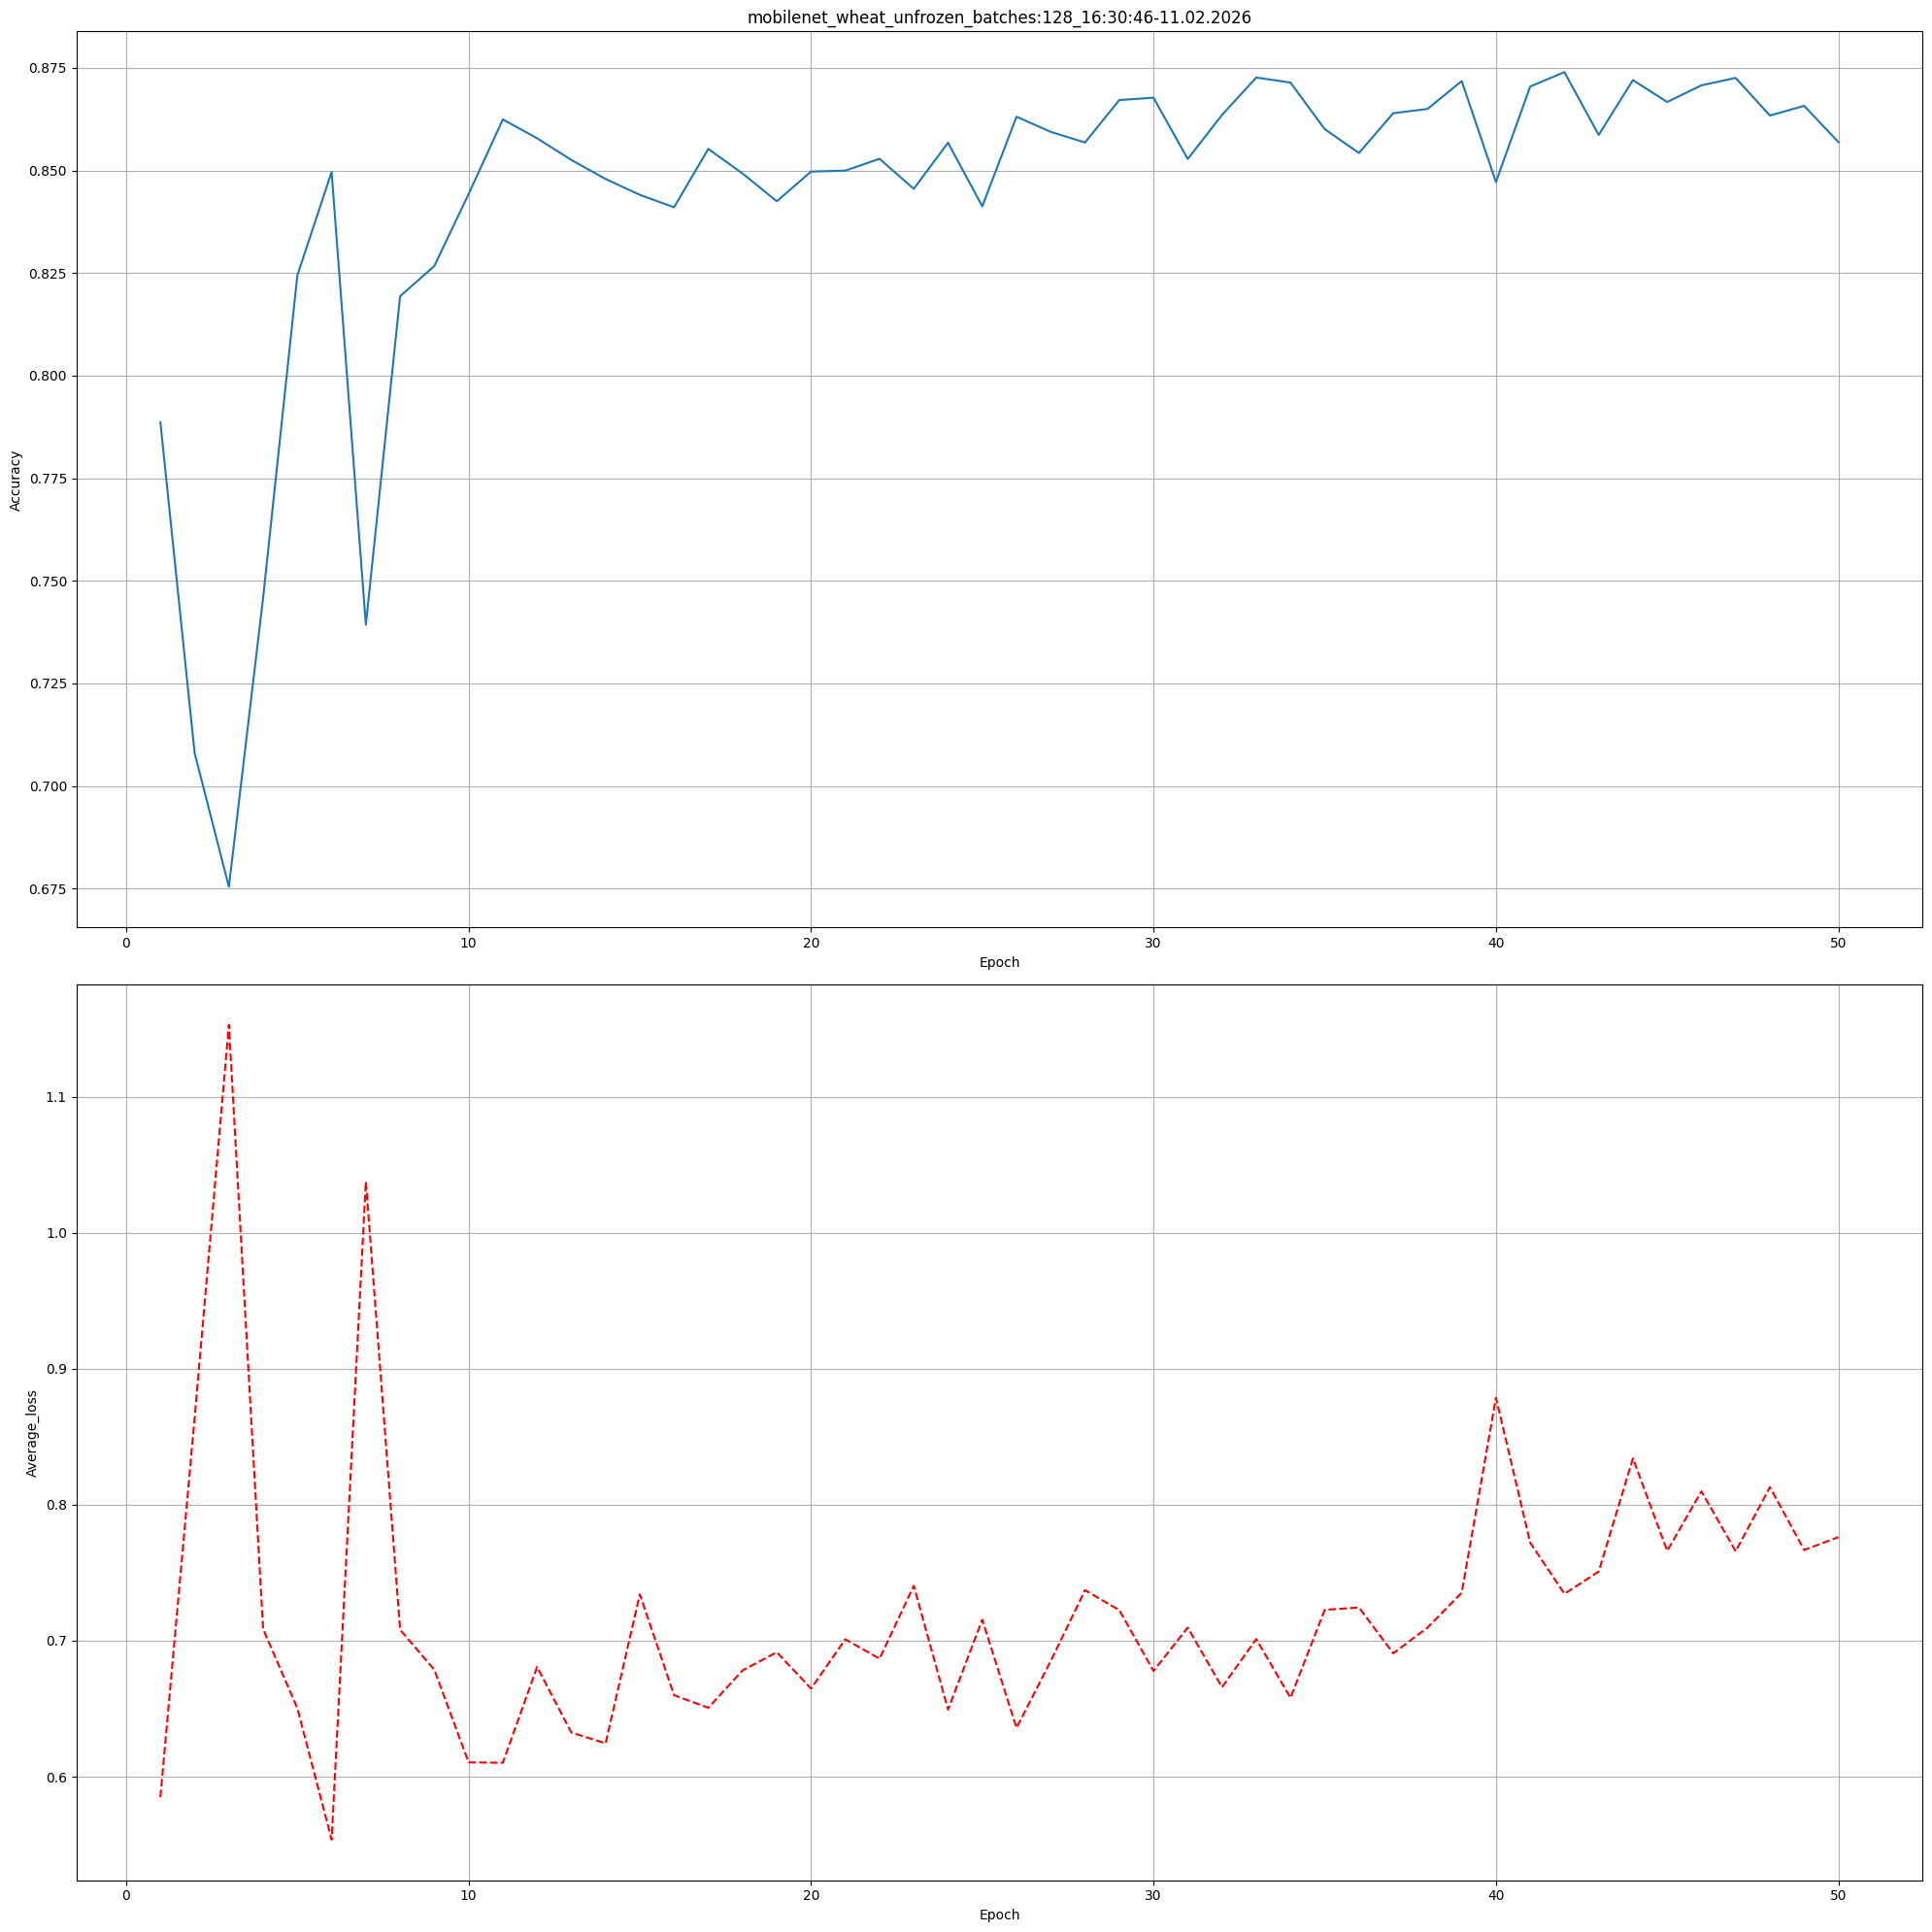

In [10]:

data_folder = 'output_data/'
files = csv_dirs(data_folder)
for f in files:
    title = Path(f).name.strip('.csv')
    df = pd.read_csv(f)
    plot_dataframe(df, title)
